# ANOVA Analysis of NBA Players: Is bigger better?

For this project, I will be analysing the relationships between NBA players' height, weight and wingspan and their playing position.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pyhomogeneity as hg
from scipy.stats import f_oneway
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

# Getting the data
In order to get the dataset, I had to get the data from 2 sources. 

## Anthoprometric Data

The first source was https://www.nba.com/stats/draft/combine-anthro/. This page contains data on all draft classes (Incoming players from college that will be selected by pro teams) by year. This gave me data for the player anthroprometric data. This data had to be manually pasted into an excel document as exporting / auto-scraping the data was proving difficult. I went back as far as 03/04 (this is the draft class that contained LeBron James, who I'm quite sure will be the earliest player drafted given the criteria I'll be using in this project). I did not include players drafted in the last year as the previous NBA season (last complete one) was used.

The data had to be copied from the webpages and, in excel, 'Paste Special' had to be selected and 'Text' selected in the pop-up menu. The excel was then saved as a CSV and ready for cleaning.

In [2]:
# Custom headers are used to remove symbols that were causing issues
headers = ['Player', 'Position', 'Body Fat', 'Hand Length', 'Hand Width', 'Height', 'Height in Shoes', 'Standing Reach', 'Weight', 'Wingspan']

# Skips first row to skip headers in original doc
df = pd.read_csv('All_Draftees_02_20.csv', names = headers, skiprows = 1)
df.head()

,Player,Position,Body Fat,Hand Length,Hand Width,Height,Height in Shoes,Standing Reach,Weight,Wingspan
0,Kris Dunn,PG,-%,-,-,6' 3'',6' 4.25'',8' 4'',0,6' 9.5''
1,Tyler Ulis,PG,5.20%,7.5,7.5,5' 8.75'',5' 10'',7' 4.5'',149.2,6' 2''
2,John Lucas III,PG,-%,-,-,5' 9.25'',5' 10.5'',7' 8'',154.4,6' 0''
3,Russ Smith,PG,3.50%,8.25,8.5,5' 11.5'',6' 0.75'',7' 11'',160,6' 3.5''
4,Daryl Dorsey,PG,-%,-,-,5' 11.25'',6' 0.5'',7' 10'',160.8,5' 11.5''


#### Notes about measurements

- Both hand length and hand size are not included in some years so will not be used
- There are 2 different heights: with shoes and without shoes. Height without shoes has more measurements and will be used as more measurements are present
- Some players do not have measurements. These may have to be obtained by other means or the players ommitted from the analysis.

In [3]:
# Only include the data we will be analysing
nbadf = df[['Player', 'Position', 'Height', 'Weight', 'Wingspan']]
nbadf.head()

,Player,Position,Height,Weight,Wingspan
0,Kris Dunn,PG,6' 3'',0,6' 9.5''
1,Tyler Ulis,PG,5' 8.75'',149.2,6' 2''
2,John Lucas III,PG,5' 9.25'',154.4,6' 0''
3,Russ Smith,PG,5' 11.5'',160,6' 3.5''
4,Daryl Dorsey,PG,5' 11.25'',160.8,5' 11.5''


In [4]:
# Strip '' from right side of Heights and Wingspans
nbadf['Height'] = nbadf.loc[:,'Height'].str.strip('\'')
nbadf['Wingspan'] = nbadf.loc[:,'Wingspan'].str.strip('\'')
nbadf.head()

<ipython-input-4-692b6f63b3c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Height'] = nbadf.loc[:,'Height'].str.strip('\'')
<ipython-input-4-692b6f63b3c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Wingspan'] = nbadf.loc[:,'Wingspan'].str.strip('\'')


,Player,Position,Height,Weight,Wingspan
0,Kris Dunn,PG,6' 3,0,6' 9.5
1,Tyler Ulis,PG,5' 8.75,149.2,6' 2
2,John Lucas III,PG,5' 9.25,154.4,6' 0
3,Russ Smith,PG,5' 11.5,160,6' 3.5
4,Daryl Dorsey,PG,5' 11.25,160.8,5' 11.5


In [5]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html
# Use string split to seperate feet and inches

nbadf[['Height Feet','Height Inches']] = nbadf.Height.str.split('\'', expand = True)
nbadf[['Wingspan Feet','Wingspan Inches']] = nbadf.Wingspan.str.split('\'', expand = True)
nbadf.head()

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Player,Position,Height,Weight,Wingspan,Height Feet,Height Inches,Wingspan Feet,Wingspan Inches
0,Kris Dunn,PG,6' 3,0,6' 9.5,6,3,6,9.5
1,Tyler Ulis,PG,5' 8.75,149.2,6' 2,5,8.75,6,2
2,John Lucas III,PG,5' 9.25,154.4,6' 0,5,9.25,6,0
3,Russ Smith,PG,5' 11.5,160,6' 3.5,5,11.5,6,3.5
4,Daryl Dorsey,PG,5' 11.25,160.8,5' 11.5,5,11.25,5,11.5


In [6]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# Use to numeric to convert column to ints / floats and calculate based on 1 foot = 40.48cm and 1 inch = 2.54cm
nbadf['Height'] = pd.to_numeric(nbadf['Height Feet']) * 30.48 + pd.to_numeric(nbadf['Height Inches']) * 2.54
nbadf['Wingspan'] = pd.to_numeric(nbadf['Wingspan Feet']) * 30.48 + pd.to_numeric(nbadf['Wingspan Inches']) * 2.54
nbadf.head()

<ipython-input-6-0bc900549f9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Height'] = pd.to_numeric(nbadf['Height Feet']) * 30.48 + pd.to_numeric(nbadf['Height Inches']) * 2.54
<ipython-input-6-0bc900549f9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Wingspan'] = pd.to_numeric(nbadf['Wingspan Feet']) * 30.48 + pd.to_numeric(nbadf['Wingspan Inches']) * 2.54


,Player,Position,Height,Weight,Wingspan,Height Feet,Height Inches,Wingspan Feet,Wingspan Inches
0,Kris Dunn,PG,190.500,0,207.01,6,3,6,9.5
1,Tyler Ulis,PG,174.625,149.2,187.96,5,8.75,6,2
2,John Lucas III,PG,175.895,154.4,182.88,5,9.25,6,0
3,Russ Smith,PG,181.610,160,191.77,5,11.5,6,3.5
4,Daryl Dorsey,PG,180.975,160.8,181.61,5,11.25,5,11.5


In [7]:
# Remove '-' characters from Weight column
nbadf.loc[:,'Weight'] = nbadf.loc[:,'Weight'].str.strip('-')

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
# Convert weight to kg using 1 pound = 0.4536kg
nbadf['Weight'] = pd.to_numeric(nbadf['Weight'])*0.4536
nbadf.head()

<ipython-input-8-3cbebf5b53db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Weight'] = pd.to_numeric(nbadf['Weight'])*0.4536


,Player,Position,Height,Weight,Wingspan,Height Feet,Height Inches,Wingspan Feet,Wingspan Inches
0,Kris Dunn,PG,190.500,0.00000,207.01,6,3,6,9.5
1,Tyler Ulis,PG,174.625,67.67712,187.96,5,8.75,6,2
2,John Lucas III,PG,175.895,70.03584,182.88,5,9.25,6,0
3,Russ Smith,PG,181.610,72.57600,191.77,5,11.5,6,3.5
4,Daryl Dorsey,PG,180.975,72.93888,181.61,5,11.25,5,11.5


In [9]:
nbadf = nbadf[['Player', 'Position', 'Height', 'Weight', 'Wingspan']]
nbadf.head()

,Player,Position,Height,Weight,Wingspan
0,Kris Dunn,PG,190.500,0.00000,207.01
1,Tyler Ulis,PG,174.625,67.67712,187.96
2,John Lucas III,PG,175.895,70.03584,182.88
3,Russ Smith,PG,181.610,72.57600,191.77
4,Daryl Dorsey,PG,180.975,72.93888,181.61


In [10]:
# Remove NaNs and 0 values
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

# Only first row has a 0 value so that row will be removed
nbadf = nbadf.loc[1:,:]

# Count rows before drop
print(nbadf.count())

# inplace = True to drop from original df
nbadf.dropna(inplace=True)

# Count rows after drop
nbadf.count()

Player      1169
Position    1164
Height      1156
Weight      1155
Wingspan    1157
dtype: int64


Player      1154
Position    1154
Height      1154
Weight      1154
Wingspan    1154
dtype: int64

In [11]:
nbadf.head()

,Player,Position,Height,Weight,Wingspan
1,Tyler Ulis,PG,174.625,67.67712,187.96
2,John Lucas III,PG,175.895,70.03584,182.88
3,Russ Smith,PG,181.610,72.57600,191.77
4,Daryl Dorsey,PG,180.975,72.93888,181.61
5,Aaron Brooks,PG,177.800,73.02960,193.04


## Player Minutes Data

The source of the player performance data in this analysis was [BasketballReference.com](https://www.basketball-reference.com/), a great site for NBA stats. The data used will be performance data from the 2020/2021 NBA season which was the last full season played. We will be looking at the top players in minutes played for the season and their positions. While both datasets will have positions for the players, the position data for BasketballReference will be used as it will be more accurate to the players' current positions.

To get the data into a dataframe, the data was exported into excel format directly from the site, sorted by minuted played. Then players outside the top 300 were removed and the 'rank' column that ranked players based on minutes played was also removed. The excel was then saved as a csv.

In [12]:
# Skips first row to skip headers in original doc
df = pd.read_csv('Player_Performance_20_21.csv')
df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Julius Randle,PF,26,NYK,71,71,2667,8.1,17.8,0.456,...,0.811,1.1,8.6,9.8,5.8,0.9,0.2,3.3,3.0,23.1
1,RJ Barrett,SG,20,NYK,72,72,2511,6.7,15.2,0.441,...,0.746,1.0,5.0,5.9,3.1,0.8,0.3,2.0,2.7,18.1
2,Nikola Jokić,C,25,DEN,72,72,2488,10.6,18.7,0.566,...,0.868,3.0,8.3,11.3,8.7,1.4,0.7,3.2,2.8,27.5
3,Buddy Hield,SG,28,SAC,71,71,2433,6.0,14.7,0.406,...,0.846,0.4,4.5,4.9,3.8,0.9,0.4,1.9,2.6,17.4
4,Damian Lillard,PG,30,POR,67,67,2398,9.0,20.0,0.451,...,0.928,0.5,3.8,4.2,7.6,0.9,0.3,3.0,1.5,28.9


In [13]:
# Filter df by columns that we want
ppdf = df[["Player", "Pos"]]

In [14]:
ppdf.head()

,Player,Pos
0,Julius Randle,PF
1,RJ Barrett,SG
2,Nikola Jokić,C
3,Buddy Hield,SG
4,Damian Lillard,PG


#### Secondary Positions
Some player have secondary positions on Bballref.com e.g. Centre-Power Forward. For the purposes of this analysis, we will be taking the first position listed as the player's primary position.

In [15]:
ppdf.iloc[20]

Player    Norman Powell
Pos               SG-SF
Name: 20, dtype: object

In [16]:
ppdf['Pos'] = ppdf.Pos.str.split('\-', expand = True)

<ipython-input-16-56a20e42e5c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppdf['Pos'] = ppdf.Pos.str.split('\-', expand = True)


In [17]:
ppdf.head()

,Player,Pos
0,Julius Randle,PF
1,RJ Barrett,SG
2,Nikola Jokić,C
3,Buddy Hield,SG
4,Damian Lillard,PG


In [18]:
ppdf.iloc[20]

Player    Norman Powell
Pos                  SG
Name: 20, dtype: object

### Joining the dataframes
Both dataframes will have to be joined before analysing. After joining, specific cases will be looked at where there are no corresponding anthroprometric data.

In [19]:
combine = ppdf.merge(nbadf, on = "Player", how = 'left')

In [20]:
combine.head()

,Player,Pos,Position,Height,Weight,Wingspan
0,Julius Randle,PF,PF,202.565,113.26392,213.360
1,RJ Barrett,SG,NaN,NaN,NaN,NaN
2,Nikola Jokić,C,NaN,NaN,NaN,NaN
3,Buddy Hield,SG,SG,192.405,96.34464,206.375
4,Damian Lillard,PG,PG,187.325,85.63968,202.565


In [21]:
# Drop second position columns
combine = combine.drop('Position', axis=1)

In [22]:
combine.head()

,Player,Pos,Height,Weight,Wingspan
0,Julius Randle,PF,202.565,113.26392,213.360
1,RJ Barrett,SG,NaN,NaN,NaN
2,Nikola Jokić,C,NaN,NaN,NaN
3,Buddy Hield,SG,192.405,96.34464,206.375
4,Damian Lillard,PG,187.325,85.63968,202.565


In [23]:
# Look at NaNs
nan = combine[combine['Height'].isna()]

In [24]:
# This option allows a full look at the dataframe
# pd.set_option('display.max_rows', None)

In [25]:
nan.head()

,Player,Pos,Height,Weight,Wingspan
1,RJ Barrett,SG,NaN,NaN,NaN
2,Nikola Jokić,C,NaN,NaN,NaN
7,Andrew Wiggins,PF,NaN,NaN,NaN
8,Mikal Bridges,SF,NaN,NaN,NaN
9,Nikola Vučević,C,NaN,NaN,NaN


In [26]:
# Remove NaNs from dataframe
combine = combine.dropna()

In [27]:
combine.head()

,Player,Pos,Height,Weight,Wingspan
0,Julius Randle,PF,202.565,113.26392,213.360
3,Buddy Hield,SG,192.405,96.34464,206.375
4,Damian Lillard,PG,187.325,85.63968,202.565
5,Terry Rozier,SG,184.150,86.27472,203.835
6,Russell Westbrook,PG,188.595,87.09120,202.565


In [28]:
# Count remaining datapoints
combine.count()

Player      180
Pos         180
Height      180
Weight      180
Wingspan    180
dtype: int64

In [29]:
# Assign positional dataframes
pgdf = combine.loc[combine['Pos'] == 'PG']
sgdf = combine.loc[combine['Pos'] == 'SG']
sfdf = combine.loc[combine['Pos'] == 'SF']
pfdf = combine.loc[combine['Pos'] == 'PF']
cdf = combine.loc[combine['Pos'] == 'C']

In [30]:
print(pgdf.count())
print(sgdf.count())
print(sfdf.count())
print(pfdf.count())
print(cdf.count())

Player      31
Pos         31
Height      31
Weight      31
Wingspan    31
dtype: int64
Player      53
Pos         53
Height      53
Weight      53
Wingspan    53
dtype: int64
Player      26
Pos         26
Height      26
Weight      26
Wingspan    26
dtype: int64
Player      41
Pos         41
Height      41
Weight      41
Wingspan    41
dtype: int64
Player      29
Pos         29
Height      29
Weight      29
Wingspan    29
dtype: int64


#### NB
The numbers of each position should be noted as it may affect normality distributions later on (Centers will tend to have more rebounds, Point Guards more assists etc.)

In [31]:
combine.mean()

Height      196.461944
Weight       96.007464
Wingspan    208.953806
dtype: float64

## Visualisation of Data

In [32]:
combine.describe()

,Height,Weight,Wingspan
count,180.000000,180.000000,180.000000
mean,196.461944,96.007464,208.953806
std,7.557780,10.127191,9.265737
min,177.800000,77.792400,187.960000
25%,191.770000,87.340680,202.406250
50%,196.215000,95.528160,208.280000
75%,201.295000,103.148640,215.265000
max,216.535000,126.372960,234.950000


In [33]:
# Assign variables to columns for visualisation
position = combine['Pos']
height = combine['Height']
weight = combine['Weight']
wingspan = combine['Wingspan']

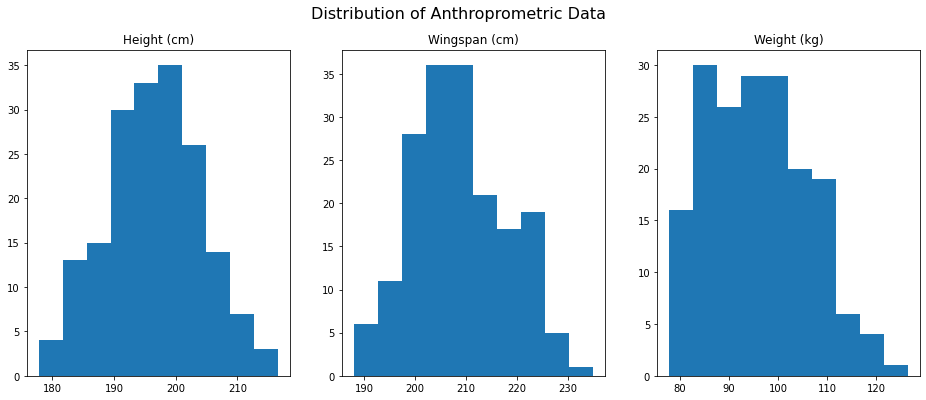

In [34]:
# Histograms to check for normal distribution of anthroprometric data
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize = (16,6))

fig.suptitle('Distribution of Anthroprometric Data', fontsize=16)

ax1.hist(height, bins=10)
ax1.set_title('Height (cm)')

ax2.hist(wingspan, bins=10)
ax2.set_title('Wingspan (cm)')

ax3.hist(weight, bins=10)
ax3.set_title('Weight (kg)');


While not anywhere close to the means of a normal population (the average height is about 196cm or just over 6ft4"), the anthroprometric data seems to be normally distributed, with weight having somewhat of a positive skewness.

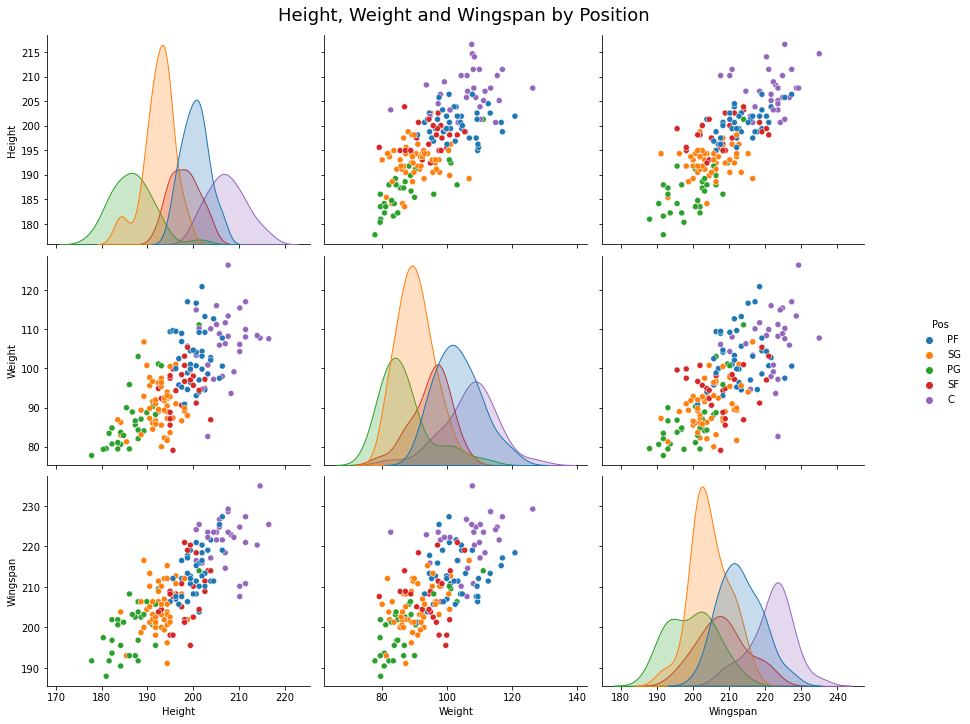

In [35]:
ax = sns.pairplot(combine, hue = "Pos");
ax.fig.suptitle("Height, Weight and Wingspan by Position", size = 18, y=1.02)
ax.fig.set_figwidth(14)
ax.fig.set_figheight(10)

## ANOVA Assumptions
ANOVA assumes [3 things.](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/anova/) These are:

 - Population is normally distributed
 - Samples are independant of each other
 - Homogeneity of Variance

### Normally Distributed Population
Visual tests above for the 3 independant variables indicate that the populations are normally distributed. Below are Shapiro-Wilks tests for normality.

In [36]:
# https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411

normaltests = [height, weight, wingspan]
for x in normaltests:
    stat, p = shapiro(x)
    print(f'Normality test for {x.name}')
    print('stat=%.3f, p=%.3f' % (stat,p))
    if p > 0.05:
        print('Probably Gaussian\n\n')
    else:
        print('Probably not Gaussian\n\n')

Normality test for Height
stat=0.995, p=0.843
Probably Gaussian


Normality test for Weight
stat=0.978, p=0.006
Probably not Gaussian


Normality test for Wingspan
stat=0.987, p=0.085
Probably Gaussian




Height and Wingspan can be considered normally distributed according to the tests above. Weight cannot be considered normally distributed, even though the histogram may appear to be (albeight with some amount of skewness). We will use weight as a variable anyway but keep in mind that it did not pass this test.

### Independant Samples
The data used can be considered independant as the variables do not impact each other across samples. One player's weight can no impact on another player's weight, same for height etc.

### Homogeneity of Variance
Below are Pettit tests for Homogeneity of Variance for the 3 independant variables.

In [37]:
# https://pypi.org/project/pyhomogeneity/
for x in normaltests:
    result = hg.pettitt_test(x)
    print(f'Homogeneity test for {x.name}')
    print(result, "\n\n")

Homogeneity test for Height
Pettitt_Test(h=False, cp=19, p=0.3931, U=1199.0, avg=mean(mu1=192.2044736842105, mu2=196.96437888198759)) 


Homogeneity test for Weight
Pettitt_Test(h=False, cp=22, p=0.6323, U=988.0, avg=mean(mu1=91.7550327272727, mu2=96.5995746835443)) 


Homogeneity test for Wingspan
Pettitt_Test(h=False, cp=28, p=0.43895, U=1161.0, avg=mean(mu1=205.58124999999998, mu2=209.5750657894737)) 




A h score of False indicates that the variables are homogenous. All 3 variables can be deemed homogenous.

### ANOVA Assumptions Summary
All 3 independant variable pass the 2nd and 3rd assumption for ANOVA testing as the sample are independant of each other and the variables are homogenous. The weight variable did not pass the Shapiro-Wilks tests for normality, however we we still include it in our ANOVA testing.

#### Other Anova Assumption
The other 3 ANOVA assumption indicated [here](https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics.php) are also satisfied:

 - The dependant variables are continuous
 - There are 2 or more (5) categorical, independant groups (The 5 positions)
 - There are no significant outliers (see dataset description)

# ANOVA Testing

### Null Hypothesis
Our null hypothesis will be that there is **no significant difference in height, weight or wingspan between NBA positions**

In [38]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

variables = ["Height", "Wingspan", "Weight"]
for x in variables:
    print(f"Anova Test for {x}")
    F, p = f_oneway(pgdf[x], sgdf[x], sfdf[x], pfdf[x], cdf[x])
    print(f"{x} F Statistic: {F}\n{x} p-value: {p}\n\n")
    

Anova Test for Height
Height F Statistic: 150.21631969344892
Height p-value: 1.765580302072586e-55


Anova Test for Wingspan
Wingspan F Statistic: 62.39709599062229
Wingspan p-value: 1.0920600240867652e-32


Anova Test for Weight
Weight F Statistic: 51.58078564318579
Weight p-value: 1.2218502040993676e-28




## ANOVA Test Results
Given the small p-values, the null hypothesis can be rejected. **There is a significant difference in height, wingspan and weight among NBA positions.**

## Post Hoc Testing
First, we will do another ANOVA test by a different method found [here.](https://scikit-posthocs.readthedocs.io/en/latest/tutorial/)

In [44]:
variables = ["Height", "Wingspan", "Weight"]
for x in variables:
    print(f"Anova Test for {x}")
    lm = sfa.ols(f'{x} ~ C(Pos)', data=combine).fit()
    anova = sa.stats.anova_lm(lm)
    print(anova, "\n\n")

Anova Test for Height
             df       sum_sq      mean_sq          F        PR(>F)
C(Pos)      4.0  7918.306478  1979.576620  150.21632  1.765580e-55
Residual  175.0  2306.180241    13.178173        NaN           NaN 


Anova Test for Wingspan
             df       sum_sq      mean_sq          F        PR(>F)
C(Pos)      4.0  9033.773264  2258.443316  62.397096  1.092060e-32
Residual  175.0  6334.070104    36.194686        NaN           NaN 


Anova Test for Weight
             df       sum_sq      mean_sq          F        PR(>F)
C(Pos)      4.0  9933.122325  2483.280581  51.580786  1.221850e-28
Residual  175.0  8425.115987    48.143520        NaN           NaN 




In [46]:
variables = ["Height", "Wingspan", "Weight"]
for x in variables:
    print(f"Post Hoc Tests for {x}")
    postHoc = sp.posthoc_ttest(combine, val_col=x, group_col='Pos', p_adjust='holm')
    print(postHoc, "\n\n")
    

Post Hoc Tests for Height
              PF            SG            PG            SF             C
PF  1.000000e+00  4.706766e-20  4.365894e-23  2.405535e-03  3.998755e-11
SG  4.706766e-20  1.000000e+00  9.272332e-09  1.469589e-09  2.458293e-28
PG  4.365894e-23  9.272332e-09  1.000000e+00  6.498016e-14  2.258912e-24
SF  2.405535e-03  1.469589e-09  6.498016e-14  1.000000e+00  7.157615e-12
C   3.998755e-11  2.458293e-28  2.258912e-24  7.157615e-12  1.000000e+00 


Post Hoc Tests for Wingspan
              PF            SG            PG            SF             C
PF  1.000000e+00  8.457479e-10  1.956018e-12  5.535820e-03  3.737113e-07
SG  8.457479e-10  1.000000e+00  1.100317e-03  1.387463e-02  6.360892e-21
PG  1.956018e-12  1.100317e-03  1.000000e+00  6.588809e-05  1.564670e-18
SF  5.535820e-03  1.387463e-02  6.588809e-05  1.000000e+00  1.215926e-09
C   3.737113e-07  6.360892e-21  1.564670e-18  1.215926e-09  1.000000e+00 


Post Hoc Tests for Weight
              PF            SG        

### Post Hoc Test Results
Almost all positions had significant differences between them for all variables. Of interest are the ones that did not. There was a significant difference in all positions in both wingspan and height, with the lowest significance coming in wingspan between Small Forwards(SF) and Shooting Guards(SG).

Tests for weight between Power Forwards (PF) and Centres (C) had a p-value of 0.07. Interestingly, the same p-value was found for Point Guards (PG) and Shooting Guards for the weight variable.

***

# Conclusion
ANOVA tests show that there is a significant difference in weight, height and wingspan between positions in the NBA. Further Post-Hoc testing shows that there is a significant difference among all positions for height and wingspan. For weight, there is a significant difference between most position, with the exception being between Centres and Power Forwards, and Point Guards and Shooting Guards.

***

# The End